# Build an agent with tool-calling power using Transformers Agents
_Authored by: [Aymeric Roucher](https://huggingface.co/m-ric)_

This notebook demonstrates how you can use **Transformers Agents** to build awesome **agents**!

What are **agents**? Agents are systems that are powered by an LLM and enable it (with careful prompting and output parsing) to use specific *tools* to solve problems.
These *tools* are basically functions that the LLM couldn't perform well by itself: for instance for a text-generation LLM like [Llama-3-70B](https://huggingface.co/meta-llama/Meta-Llama-3-70B-Instruct), this could be an image generation tool, a web search tool, a calculator...

What is **Transformers Agents**? it's an extension of our `transformers` library that provides building blocks to build your own agents! Learn more about it in the [documentation](https://huggingface.co/docs/transformers/en/transformers_agents).

Let's see how to use it, and which use cases it can solve.

We install transformers agents from source since it has not been released as of writing, but later this week when it gets release you can simply install it with `pip install transformers[agents]`.

In [ ]:
!pip install "git+https://github.com/huggingface/transformers.git#egg=transformers[agents]"

In [ ]:
!pip install huggingface_hub langchain sentence-transformers faiss-cpu serpapi google-search-results -q

## 🏞️ Multimodal + 🌐 Web-browsing assistant

For this use case, we want to show an agent that browses the web and is able to generate image.

To build it, we simply need to have two tools ready: image generation and web search.
- For image generation, we load a tool from the Hub that uses the HF Inference API (Serverless) to generate images using Stable Diffusion.
- For the web search, we load a LangChain tool.

/Users/aymeric/venvs/test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You're loading a tool from the Hub from None. Please make sure this is a source that you trust as the code within that tool will be executed on your machine. Always verify the code of the tools that you load. We recommend specifying a `revision` to ensure you're loading the code that you have checked.
======== New task ========
Generate me a photo of the car that James bond drove in the latest movie.
==== Agent is executing the code below:
latest_movie = search("latest James Bond movie")
print("Latest movie:", latest_movie)
====
Print outputs:
Latest movie: No Time to Die

==== Agent is executing the code below:
bond_car = search("what car did James Bond drive in No Time to Die")
print("James Bond's car:", bond_car)
====
Print out

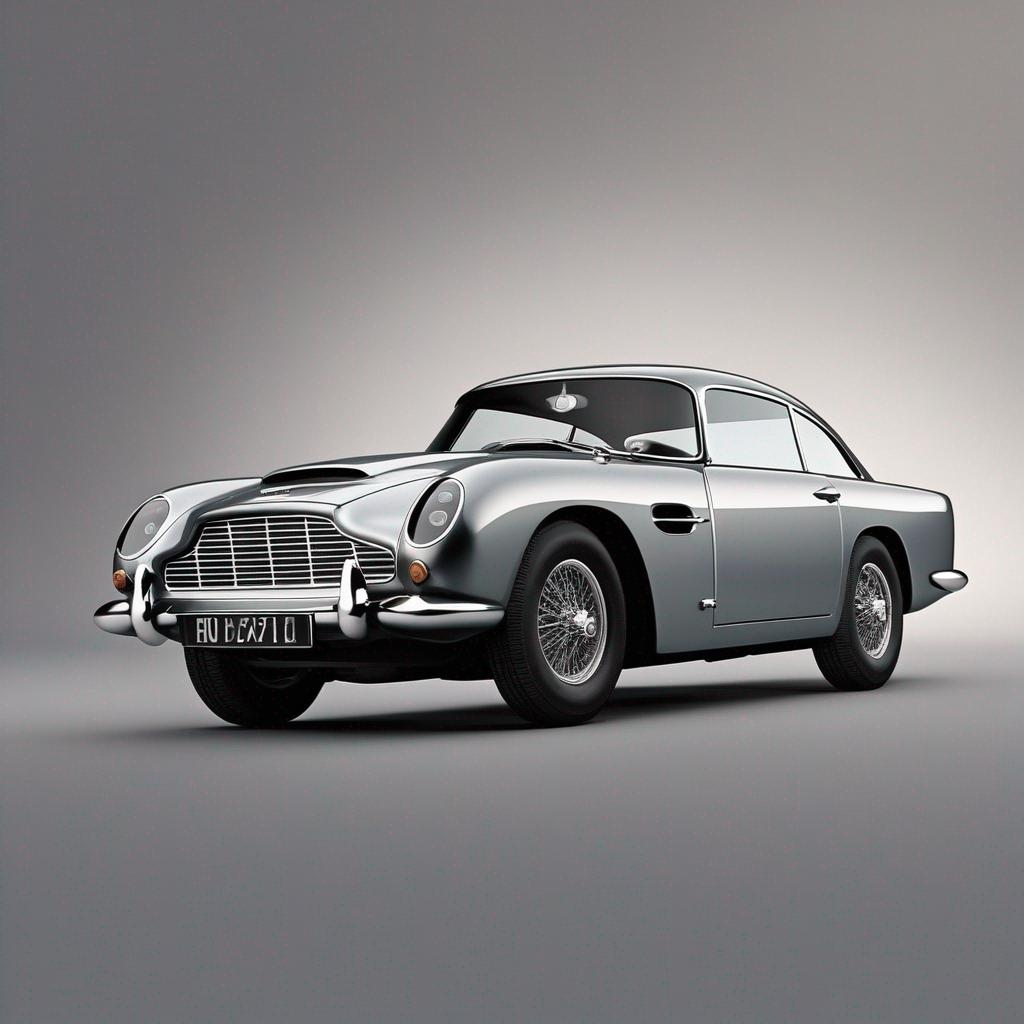

In [1]:
from transformers import Tool, load_tool, ReactCodeAgent, HfEngine
from langchain.agents import load_tools

# Import tool from hub
image_generation_tool = load_tool("m-ric/text-to-image")

# Import tool from LangChain
search_tool = Tool.from_langchain(load_tools(["serpapi"])[0])

llm_engine = HfEngine("meta-llama/Meta-Llama-3-70B-Instruct")
# Initialize the agent with both tools
agent = ReactCodeAgent(
    tools=[image_generation_tool, search_tool], llm_engine=llm_engine
)

# Run it!
agent.run("Generate me a photo of the car that James bond drove in the latest movie.")

## 📚💬 Retrieval-Augmented Generation with source selection

Quick definition: Retrieval-Augmented-Generation (RAG) is “using an LLM to answer a user query, but basing the answer on information retrieved from a knowledge base”. It has many advantages over using a vanilla or fine-tuned LLM: to name a few, it allows to ground the answer on true facts and reduce confabulations, it allows to provide the LLM with domain-specific knowledge, and it allows fine-grained control of access to information from the knowledge base.

see our many other RAG-related cookbooks to learn more.

Now let’s say we want to perform RAG, and some parameters must be dynamically generated. For example, depending on the user query we could want to restrict the search to specific subsets of the knowledge base, or we could want to adjust the number of documents retrieved. The difficulty is: how to dynamically adjust these parameters based on the user query?

Well, we can do this by giving our agent an access to these parameters!

🔧 Let's build this system. 

We first load a knowledge base on which we want to perform RAG: this dataset is a compilation of the documentation pages for many `huggingface` packages, stored as markdown.


In [2]:
import datasets

knowledge_base = datasets.load_dataset("m-ric/huggingface_doc", split="train")

/Users/aymeric/venvs/test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now we prepare the knowledge base by processing the dataset and storing it into a vector database to be used by the retriever. We are going to use LangChain, since it features excellent utilities for vector databases:


In [ ]:
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings

source_docs = [
    Document(page_content=doc["text"], metadata={"source": doc["source"].split("/")[1]})
    for doc in knowledge_base
]

docs_processed = RecursiveCharacterTextSplitter(chunk_size=500).split_documents(
    source_docs
)[:1000]

embedding_model = HuggingFaceEmbeddings(model_name="thenlper/gte-small")
vectordb = FAISS.from_documents(documents=docs_processed, embedding=embedding_model)

Now that we have the database ready, let’s build a RAG system that answers user queries based on it!

We want our system to select only from the most relevant sources of information, depending on the query.

Our documentation pages come from the following sources:

In [9]:
all_sources = list(set([doc.metadata["source"] for doc in docs_processed]))
all_sources

In [10]:
import json
from transformers.agents import Tool
from langchain_core.vectorstores import VectorStore


class RetrieverTool(Tool):
    name = "retriever"
    description = "Retrieves some documents from the knowledge base that have the closest embeddings to the input query."
    inputs = {
        "query": {
            "type": "text",
            "description": "The query to perform. This should be semantically close to your target documents. Use the affirmative form rather than a question.",
        },
        "source": {"type": "text", "description": ""},
    }
    output_type = "text"

    def __init__(self, vectordb: VectorStore, all_sources: str, **kwargs):
        super().__init__(**kwargs)
        self.vectordb = vectordb
        self.inputs["source"][
            "description"
        ] = f"The source of the documents to search, as a str representation of a list. Possible values in the list are: {all_sources}. If this argument is not provided, all sources will be searched."

    def forward(self, query: str, source: str = None) -> str:
        assert isinstance(query, str), "Your search query must be a string"

        if source:
            if isinstance(source, str) and "[" not in str(
                source
            ):  # if the source is not representing a list
                source = [source]
            source = json.loads(str(source).replace("'", '"'))

        docs = self.vectordb.similarity_search(
            query, filter=({"source": source} if source else None), k=3
        )

        if len(docs) == 0:
            return "No documents found with this filtering. Try removing the source filter."
        return "Retrieved documents:\n\n" + "\n===Document===\n".join(
            [doc.page_content for doc in docs]
        )

### [Optional]: share your Retriever tool to Hub

To share your tool to the Hub, first copy-paste the code in the RetrieverTool definition cell to a new file named for instance `retriever.py`.

whan the tool is loaded from a separate file, you can then push it to the Hub using the code below (make sure to have used a write token)

In [ ]:
from huggingface_hub import login

login("your_hub_token_with_write_access")

retriever_tool.push_to_hub(repo_id="m-ric/langchain-retriever-tool")

### Run the agent!

In [11]:
from transformers.agents import HfEngine, ReactJsonAgent

llm_engine = HfEngine("meta-llama/Meta-Llama-3-70B-Instruct")

agent = ReactJsonAgent(
    tools=[RetrieverTool(vectordb, all_sources)], llm_engine=llm_engine
)

agent_output = agent.run("Please show me a LORA finetuning script")

print("Final output:")
print(agent_output)

======== New task ========
Please show me a LORA finetuning script
Calling tool: 'retriever' with arguments: {'query': 'LORA finetuning script', 'source': 'transformers'}
Calling tool: 'retriever' with arguments: {'query': 'LORA finetuning script'}
Calling tool: 'final_answer' with arguments: {'answer': 'https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/text_to_image_lora.py'}


Final output:
https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/text_to_image_lora.py


## ➡️ Conclusion

These two use cases should give you a glimpse into the possibilities of our Agents framework!

For more advanced usage, read the [documentation](https://huggingface.co/docs/transformers/en/transformers_agents), and [this experiment](https://github.com/aymeric-roucher/agent_reasoning_benchmark/blob/main/benchmark_gaia.ipynb) that allowed us to build our own agent based on Llama-3-70B that beats many GPT-4 agents on the very difficult [GAIA Leaderboard](https://huggingface.co/spaces/gaia-benchmark/leaderboard)!

All feedback is welcome, it will help us improve the framework together! 🚀